## Clone and install custom gym

In [0]:
# Clone and install Sigurds version of the gym
!git clone -b master_student_branch https://github.com/sigurdhjerde/gym.git

%cd gym/
!git branch

!ls
!pip install -e .

Cloning into 'gym'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 10116 (delta 0), reused 0 (delta 0), pack-reused 10111
Receiving objects: 100% (10116/10116), 5.18 MiB | 21.12 MiB/s, done.
Resolving deltas: 100% (6897/6897), done.
/content/gym
* master_student_branch
bin		     LICENSE.md		   scripts		  tox.ini
CODE_OF_CONDUCT.rst  Makefile		   setup.py		  unittest.cfg
docs		     README.rst		   test.dockerfile.14.04  vendor
examples	     requirements_dev.txt  test.dockerfile.16.04
gym		     requirements.txt	   test.dockerfile.18.04
Obtaining file:///content/gym
ERROR: stable-baselines 2.2.1 has requirement gym[atari,classic_control]>=0.10.9, but you'll have gym 0.10.8 which is incompatible.
  Found existing installation: gym 0.15.4
    Uninstalling gym-0.15.4:
      Successfully uninstalled gym-0.15.4
  Running setup.py develop for gym


## Import modules

In [0]:
import random
from collections import deque

import gym
import numpy as np

from gym.envs.diabetes.meal_generator.meal_generator import meal_generator

import torch as th
import torch.nn as nn
import torch.optim as optim

from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# **Prioritized replay buffer class**

In [0]:
class PrioritizedReplayBuffer(object):
  def __init__(self, capacity, alpha=0.6):
    self.buffer = []
    self.capacity = capacity
    self.alpha = alpha
    self.position = 0
    self.priorities = np.zeros((capacity,), dtype=np.float32)

  
  def push(self, state, action, reward, next_state, done):
    assert state.ndim == next_state.ndim

    state      = np.expand_dims(state, 0)
    next_state = np.expand_dims(next_state, 0)

    max_priority = self.priorities.max() if self.buffer else 1.0

    if len(self.buffer) < self.capacity:
      self.buffer.append((state, action, reward, next_state, done))
    else:
      self.buffer[self.position] = (state, action, reward, next_state, done)
    
    self.priorities[self.position] = max_priority
    self.position = (self.position + 1) % self.capacity

  
  def sample(self, batch_size, beta=0.4):
    if len(self.buffer) == self.capacity:
      priorities = self.priorities
    else:
      priorities = self.priorities[:self.position]
    
    probs = priorities ** self.alpha
    probs /= probs.sum()

    idx     = np.random.choice(len(self.buffer), batch_size, p=probs)
    samples = [self.buffer[idx] for i in idx]

    buffer_size = len(self.buffer)
    weights     = (buffer_size * probs[idx]) ** (-beta)
    weights    /= weights.max()
    weights     = np.array(weights, dtype=np.float32)

    batch       = zip(*samples)
    states      = np.concatenate(batch[0])
    actions     = batch[1]
    rewards     = batch[2]
    next_states = np.concatenate(batch[3])
    dones       = batch[4]

    return states, actions, rewards, next_states, dones, idx, weights
  

  def update_priorities(self, batch_idx, batch_priorities):
    for idx, prio in zip(batch_idx, batch_priorities):
      self.priorities[idx] = prio
    
    
  
  def __len__(self):
    return len(self.buffer)

## Initiate environment

In [0]:
env_id = 'HovorkaCambridge-v0'
db = gym.make(env_id)

/content/gym/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


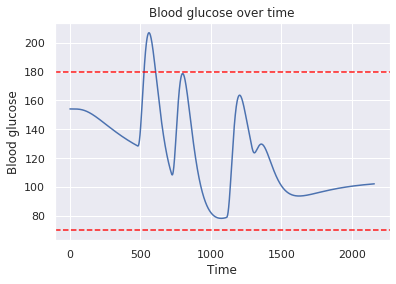

In [0]:
done = False
state = db.reset()
while not done:
    state, reward, done, _ = db.step(1)

plt.figure()
plt.plot(db.env.bg_history)
plt.title('Blood glucose over time')
plt.xlabel('Time')
plt.ylabel('Blood glucose')
plt.axhline(y=70, c='red', ls='--', alpha=0.9)
plt.axhline(y=180, c='red', ls='--', alpha=0.9)

## Hyperparameters

In [0]:
N_states = db.observation_space.shape[0]
N_actions = db.action_space.n

learning_rate = 1e-3
buffer_size = int(1e5)
batch_size = 128
gamma = 0.99
max_steps = int(1e5)

beta_init = 0.4
beta_steps = 5000

beta_by_step = lambda t: min(1.0, beta_init + t * (1.0 - beta_init) / beta_steps)

eps_init  = 1.0
eps_end   = 0.01
eps_decay = 2e4

eps_by_step = lambda t: eps_end + (eps_init - eps_end) * np.exp(-1.*t / eps_decay)

# **Deep Q Network**

In [0]:
class DQN(nn.Module):
  def __init__(self, N_states, N_actions):
    super(DQN, self).__init__()

    self.layers = nn.Sequential(
        nn.Linear(N_states, 64),
        nn.ReLU(),
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Linear(64, N_actions)
    )
  
  def forward(self, x):
    return self.layers(x)
  
  def choose_action(self, state, epsilon):
    if random.random() > epsilon:
      state  = th.FloatTensor(state).unsqueeze(0)
      q      = self.forward(state)
      action = np.argmax(q.detach().numpy())
    else:
      action = random.randrange(N_actions)
    return action

## Initiate models, optimizer, loss function and replay buffer

In [0]:
model_local   = DQN(N_states, N_actions)
model_target  = DQN(N_states, N_actions)
optimizer     = optim.Adam(model_local.parameters(), lr=learning_rate)
loss          = nn.MSELoss()
replay_buffer = PrioritizedReplayBuffer(buffer_size)

## Target network update

In [0]:
def update_target(model_local, model_target):
  model_target.load_state_dict(model_local.state_dict())

In [0]:
update_target(model_local, model_target)

# **Learn function**

In [0]:
def learn(batch_size, beta):
  state, action, reward, next_state, done, idx, weights = replay_buffer.sample(batch_size, beta)

  state      = th.FloatTensor(np.float32(state))
  action     = th.LongTensor(action)
  reward     = th.FloatTensor(reward)
  next_state = th.FloatTensor(np.float32(next_state))
  done       = th.FloatTensor(done)
  weights    = th.FloatTensor(weights)

  q_values_current = model_local(state)
  q_values_next    = model_target(next_state)

  Q          = q_values_current.gather(1, action.unsqueeze(1)).squeeze(1)
  Q_next     = q_values_next.max(1)[0]
  Q_expected = reward + gamma * Q_next * (1 - done)

  loss_train = loss(Q, Q_expected.detach()) * weights
  priorities = loss_train + 1e-5
  loss_train = loss_train.mean()

  optimizer.zero_grad()
  loss_train.backward()
  replay_buffer.update_priorities(idx, priorities.data.numpy())
  optimizer.step()

  return train_loss

# **Train model**

In [0]:
loss_list      = []
reward_list    = []
epsiode_reward = 0
episode_count  = 0

meals, meal_indicator = meal_generator()
db.env.meals          = meals
db.env.meal_indicator = meal_indicator

state = db.reset()

for t in range(1, max_steps + 1):
  epsilon = eps_by_step(t)

  action = model_local.choose_action(state, epsilon)
  next_state, reward, done, _ = db.step(action)

  replay_buffer.push(state, action, reward, next_state, done)

  state = next_state
  epsiode_reward += reward

  if done:
    meals, meal_indicator = meal_generator()
    db.env.meals          = meals
    db.env.meal_indicator = meal_indicator

    state = db.reset()

    reward_list.append(epsiode_reward)
    epsiode_reward = 0
    episode_count += 1

    if episode_count % 100 == 0:
      print("Episode: {}".format(episode_count))
      print("Time step: {}".format(t))
      print("Mean 100 episode reward: {}".format(np.mean(reward_list[-100:])))
      print("Epsilon: {}".format(epsilon))
  

  if replay_buffer.__len__() > batch_size:
    beta = beta_by_step(t)
    loss_train = learn(batch_size, beta)
    loss_list.append(loss_train.item())
  
  if t % 100 == 0:
    update_target(model_local, model_target)